<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

You work for a real estate company interested in using data science to determine the best properties to buy and re-sell. Specifically, your company would like to identify the characteristics of residential houses that estimate the sale price and the cost-effectiveness of doing renovations.

There are three components to the project:

1. Estimate the sale price of properties based on their "fixed" characteristics, such as neighborhood, lot size, number of stories, etc.


2. Estimate the impact of possible renovations to properties from the variation in sale price not explained by the fixed characteristics.  

3. Bonus Question: Determine the features in the housing data that best predict "abnormal" sales (foreclosures, etc.).

#### The full description of the data features can be found in a separate file in the project-3 repo: data_description.txt

#### For question one and two you will likely need to test different models to arrive at your "best model" for each question. This should not be an exhaustive exercise as the cleaning and eda ahead is significant enough by itself.  



#### This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).



In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import dtale 

sns.set_style('whitegrid')
import patsy
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.metrics import r2_score
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge
from sklearn import metrics
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.metrics import r2_score
# initialize the Scaler
ss = StandardScaler()


plt.style.use('fivethirtyeight')


%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---
 

#### Q1. You need to build a reliable estimator/model for the price of the house given characteristics of the house that CANNOT be renovated. 


#### Some examples of fixed and renovateble featurs include:

#### Fixed features
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

 

#### Renovateable features:(these are some examples of renovateable features that you will include in your model for question two)
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

 

### **Your goals for question one:**
 - Perform any cleaning, feature engineering, and EDA you deem necessary.
 - Be sure to remove any houses that are not residential from the dataset.
 - Identify **fixed** features that can predict price.
 - Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
 - Characterize your model. How well does it perform? What are the best estimates of price?

 

# Lets start off with some EDA 

In [2]:
# Load the data
houseall = pd.read_csv('./housing.csv')

In [3]:
#Lets get rid of non-residential 
houseall = houseall[houseall.MSZoning!= "A"]
houseall = houseall[houseall.MSZoning!= "C"]
houseall = houseall[houseall.MSZoning!= "FV"]
houseall = houseall[houseall.MSZoning!= "I"]

#Done!


In [4]:
#For these, replace the "NaN" values with "NA" so that they can be represented as categorical data through binarisation


In [5]:

houseall["Alley"] = houseall["Alley"].fillna("NA")

houseall["FireplaceQu"] = houseall["FireplaceQu"].fillna("NA")

houseall["GarageQual"] = houseall["GarageQual"].fillna("NA")

houseall["GarageFinish"] = houseall["GarageFinish"].fillna("NA")

houseall["GarageCond"] = houseall["GarageCond"].fillna("NA")

houseall["GarageType"] = houseall["GarageType"].fillna("NA")

houseall["PoolQC"] = houseall["PoolQC"].fillna("NA")

houseall["Fence"] = houseall["Fence"].fillna("NA")

houseall["MiscFeature"] = houseall["MiscFeature"].fillna("NA")

houseall["BsmtQual"] = houseall["BsmtQual"].fillna("NA")

houseall["BsmtCond"] = houseall["BsmtCond"].fillna("NA")

houseall["BsmtFinType1"]= houseall["BsmtCond"].fillna("NA")

houseall["BsmtQual"] = houseall["BsmtQual"].fillna("NA")

houseall["BsmtExposure"] = houseall["BsmtExposure"].fillna("NA")

houseall.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      251
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [6]:

#Don't really underdstand how they dont have electricy- since only one house will drop the row

houseall["Electrical"] = houseall["Electrical"].dropna

In [7]:
houseall["MasVnrArea"]#.unique()

0       196.0
1         0.0
2       162.0
3         0.0
4       350.0
        ...  
1455      0.0
1456    119.0
1457      0.0
1458      0.0
1459      0.0
Name: MasVnrArea, Length: 1395, dtype: float64

In [8]:
houseall.columns
houseall.dtypes.head
houseall.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1395 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1395 non-null   int64  
 1   MSSubClass     1395 non-null   int64  
 2   MSZoning       1395 non-null   object 
 3   LotFrontage    1144 non-null   float64
 4   LotArea        1395 non-null   int64  
 5   Street         1395 non-null   object 
 6   Alley          1395 non-null   object 
 7   LotShape       1395 non-null   object 
 8   LandContour    1395 non-null   object 
 9   Utilities      1395 non-null   object 
 10  LotConfig      1395 non-null   object 
 11  LandSlope      1395 non-null   object 
 12  Neighborhood   1395 non-null   object 
 13  Condition1     1395 non-null   object 
 14  Condition2     1395 non-null   object 
 15  BldgType       1395 non-null   object 
 16  HouseStyle     1395 non-null   object 
 17  OverallQual    1395 non-null   int64  
 18  OverallC

In [9]:
houseall["MasVnrType"].unique()

array(['BrkFace', 'None', 'Stone', 'BrkCmn', nan], dtype=object)

In [10]:
houseall.loc[houseall["MasVnrType"]== "NaN"]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [11]:
houseall["MasVnrType"].isnull().sum()

5

In [12]:
#Doesnt seem to be a clear reason as to why they havent been given a value, so am going to drop these values 
#Feel that every houseall has to have a masonary veneer- as this is the external wall component for housealls
houseall = houseall[houseall["MasVnrType"].notna()]

In [13]:
houseall.shape

(1390, 81)

In [14]:
#Done with Masvnr, now onto the next one 

In [15]:
houseall.BsmtExposure.isnull().sum()

0

In [16]:
#Does nan = no basement? lets check 

In [17]:
houseall.BsmtExposure.unique()

array(['No', 'Gd', 'Mn', 'Av', 'NA'], dtype=object)

In [18]:
#Now onto GarageType 

In [19]:
houseall.GarageType.unique

<bound method Series.unique of 0       Attchd
1       Attchd
2       Attchd
3       Detchd
4       Attchd
         ...  
1455    Attchd
1456    Attchd
1457    Attchd
1458    Attchd
1459    Attchd
Name: GarageType, Length: 1390, dtype: object>

In [20]:
houseall.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1390 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1390 non-null   int64  
 1   MSSubClass     1390 non-null   int64  
 2   MSZoning       1390 non-null   object 
 3   LotFrontage    1141 non-null   float64
 4   LotArea        1390 non-null   int64  
 5   Street         1390 non-null   object 
 6   Alley          1390 non-null   object 
 7   LotShape       1390 non-null   object 
 8   LandContour    1390 non-null   object 
 9   Utilities      1390 non-null   object 
 10  LotConfig      1390 non-null   object 
 11  LandSlope      1390 non-null   object 
 12  Neighborhood   1390 non-null   object 
 13  Condition1     1390 non-null   object 
 14  Condition2     1390 non-null   object 
 15  BldgType       1390 non-null   object 
 16  HouseStyle     1390 non-null   object 
 17  OverallQual    1390 non-null   int64  
 18  OverallC

In [21]:
#now to change those meddlesome objects to a categorical data 

In [22]:
houseall[["Street","LotShape","LandContour","LotConfig","Neighborhood","Condition1","Condition2","BldgType","HouseStyle",
         "RoofStyle","Exterior1st","Exterior2nd","MasVnrType","Foundation","BsmtExposure","BsmtFinType2",
         "KitchenQual","GarageType","PavedDrive"]] = houseall[["Street","LotShape","LandContour","LotConfig","Neighborhood","Condition1","Condition2","BldgType","HouseStyle",
         "RoofStyle","Exterior1st","Exterior2nd","MasVnrType","Foundation","BsmtExposure","BsmtFinType2",
         "KitchenQual","GarageType","PavedDrive"]].astype("category")


In [23]:
#now to do the same w/ continuous 
houseall.GarageYrBlt.isnull().sum()

81

In [24]:
houseall.GarageYrBlt.unique()

array([2003., 1976., 2001., 1998., 2000., 1993., 2004., 1973., 1931.,
       1939., 1965., 2005., 1962., 2006., 1960., 1991., 1970., 1967.,
       1958., 1930., 2002., 1968., 2007., 2008., 1957., 1920., 1966.,
       1959., 1995., 1954., 1953.,   nan, 1983., 1977., 1997., 1985.,
       1963., 1981., 1964., 1935., 1990., 1945., 1987., 1989., 1915.,
       1956., 1948., 1974., 1950., 1961., 1921., 1900., 1999., 1979.,
       2009., 1951., 1969., 1936., 1975., 1971., 1923., 1984., 1926.,
       1955., 1986., 1988., 1916., 1932., 1972., 1918., 1980., 1924.,
       1996., 1940., 1949., 1994., 1910., 1978., 1982., 1992., 1925.,
       1941., 2010., 1927., 1947., 1937., 1942., 1938., 1952., 1928.,
       1922., 1934., 1906., 1914., 1946., 1908., 1929., 1933.])

In [25]:
#Just going to drop these as only 81 
houseall["GarageYrBlt"] = houseall["GarageYrBlt"].dropna

In [26]:
houseall.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1390 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             1390 non-null   int64   
 1   MSSubClass     1390 non-null   int64   
 2   MSZoning       1390 non-null   object  
 3   LotFrontage    1141 non-null   float64 
 4   LotArea        1390 non-null   int64   
 5   Street         1390 non-null   category
 6   Alley          1390 non-null   object  
 7   LotShape       1390 non-null   category
 8   LandContour    1390 non-null   category
 9   Utilities      1390 non-null   object  
 10  LotConfig      1390 non-null   category
 11  LandSlope      1390 non-null   object  
 12  Neighborhood   1390 non-null   category
 13  Condition1     1390 non-null   category
 14  Condition2     1390 non-null   category
 15  BldgType       1390 non-null   category
 16  HouseStyle     1390 non-null   category
 17  OverallQual    1390 non-null   in

In [27]:
houseall.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      249
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [28]:
houseall["BsmtFinType2"] = houseall["BsmtFinType2"].astype(str)

In [29]:
houseall["BsmtFinType2"] = houseall["BsmtFinType2"].fillna("NA")

In [30]:
houseall.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      249
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [31]:
#Now lets split it up so that house = just our fixed features

In [32]:
house = houseall[["MasVnrArea","TotalBsmtSF","BsmtFinSF1", "BsmtUnfSF","MoSold","SaleType", "SaleCondition","YrSold","SalePrice","MSSubClass","LotArea","Street","LotShape","LandContour","LotConfig","Neighborhood","Condition1","Condition2","BldgType","HouseStyle","YearBuilt","YearRemodAdd","RoofStyle","Exterior1st","Exterior2nd","MasVnrType","Foundation","BsmtExposure","BsmtFinType2","BsmtFinSF2","1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea","BsmtFullBath","BsmtHalfBath","FullBath","HalfBath","BedroomAbvGr","KitchenAbvGr","KitchenQual","TotRmsAbvGrd","Fireplaces","GarageType","GarageYrBlt","GarageCars","GarageArea","PavedDrive","WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch","PoolArea","MiscVal"]]

In [33]:
#for the train test! 
fixed_train = house.loc[house.YrSold < 2010]
fixed_test = house.loc[house.YrSold >= 2010]


In [34]:
fixed_train

,MasVnrArea,TotalBsmtSF,BsmtFinSF1,BsmtUnfSF,MoSold,SaleType,SaleCondition,YrSold,SalePrice,MSSubClass,...,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,196.0,856,706,150,2,WD,Normal,2008,208500,60,...,2,548,Y,0,61,0,0,0,0,0
1,0.0,1262,978,284,5,WD,Normal,2007,181500,20,...,2,460,Y,298,0,0,0,0,0,0
2,162.0,920,486,434,9,WD,Normal,2008,223500,60,...,2,608,Y,0,42,0,0,0,0,0
3,0.0,756,216,540,2,WD,Abnorml,2006,140000,70,...,3,642,Y,0,35,272,0,0,0,0
4,350.0,1145,655,490,12,WD,Normal,2008,250000,60,...,3,836,Y,192,84,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,194.0,1573,0,1573,5,New,Partial,2009,287090,20,...,3,840,Y,0,36,0,0,0,0,0
1452,80.0,547,547,0,5,WD,Normal,2006,145000,180,...,2,525,Y,0,28,0,0,0,0,0
1453,0.0,1140,0,1140,7,WD,Abnorml,2006,84500,20,...,0,0,Y,36,56,0,0,0,0,0
1455,0.0,953,0,953,8,WD,Normal,2007,175000,60,...,2,460,Y,0,40,0,0,0,0,0


In [35]:
fixed_test

,MasVnrArea,TotalBsmtSF,BsmtFinSF1,BsmtUnfSF,MoSold,SaleType,SaleCondition,YrSold,SalePrice,MSSubClass,...,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
16,180.0,1004,578,426,3,WD,Normal,2010,149000,20,...,2,480,Y,0,0,0,0,0,0,700
24,0.0,1060,188,204,5,WD,Normal,2010,154000,20,...,1,270,Y,406,90,0,0,0,0,0
26,0.0,900,234,180,5,WD,Normal,2010,134800,20,...,2,576,Y,222,32,0,0,0,0,0
27,200.0,1704,1218,486,5,WD,Normal,2010,306000,20,...,3,772,Y,0,50,0,0,0,0,0
33,0.0,1398,1018,380,4,WD,Normal,2010,165500,20,...,2,447,Y,0,38,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1438,0.0,912,600,312,4,WD,Normal,2010,149700,20,...,2,923,Y,0,158,158,0,0,0,0
1446,189.0,1188,593,595,4,WD,Normal,2010,157900,20,...,1,312,P,261,39,0,0,0,0,0
1456,119.0,1542,790,589,2,WD,Normal,2010,210000,20,...,2,500,Y,349,0,0,0,0,0,0
1457,0.0,1152,275,877,5,WD,Normal,2010,266500,70,...,1,252,Y,0,60,0,0,0,0,2500


In [36]:
#dummy time !! - first with categorical 

In [37]:
To_dummytrain = fixed_train[["Street","LotShape","LandContour","LotConfig","Neighborhood","Condition1","Condition2","BldgType","HouseStyle",
          "RoofStyle","Exterior1st","Exterior2nd","MasVnrType","Foundation","BsmtExposure","BsmtFinType2",
          "KitchenQual","GarageType","PavedDrive"]]
To_dummytest = fixed_test[["Street","LotShape","LandContour","LotConfig","Neighborhood","Condition1","Condition2","BldgType","HouseStyle",
          "RoofStyle","Exterior1st","Exterior2nd","MasVnrType","Foundation","BsmtExposure","BsmtFinType2",
          "KitchenQual","GarageType","PavedDrive"]]

In [38]:
fixeddummytrain = pd.get_dummies(data=To_dummytrain, drop_first = True )
fixeddummytest = pd.get_dummies(data=To_dummytest, drop_first = True)

In [39]:
fixeddummytrain

,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,...,KitchenQual_Gd,KitchenQual_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,PavedDrive_P,PavedDrive_Y
0,1,0,0,1,0,0,1,0,0,0,...,1,0,1,0,0,0,0,0,0,1
1,1,0,0,1,0,0,1,0,1,0,...,0,1,1,0,0,0,0,0,0,1
2,1,0,0,0,0,0,1,0,0,0,...,1,0,1,0,0,0,0,0,0,1
3,1,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,1
4,1,0,0,0,0,0,1,0,1,0,...,1,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,1,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1452,1,0,0,1,0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,0,1
1453,1,0,0,1,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,1
1455,1,0,0,1,0,0,1,0,0,0,...,0,1,1,0,0,0,0,0,0,1


In [40]:
fixednotcattrain = fixed_train[["SalePrice","MSSubClass","BsmtFinSF2"
,"BsmtFullBath","BsmtHalfBath","FullBath","HalfBath","BedroomAbvGr","KitchenAbvGr","TotRmsAbvGrd","GarageCars","WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch","MiscVal"]]  

In [41]:
fixednotcattest=fixed_test[["SalePrice","MSSubClass","BsmtFinSF2"
,"BsmtFullBath","BsmtHalfBath","FullBath","HalfBath","BedroomAbvGr","KitchenAbvGr","TotRmsAbvGrd","GarageCars","WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch","MiscVal"]]

In [42]:
#now create dummies for continuous variables 
fixed_conttrain = fixed_train[["PoolArea","YearBuilt","Fireplaces","GrLivArea",
"1stFlrSF","2ndFlrSF","LowQualFinSF","MasVnrArea","TotalBsmtSF","BsmtFinSF1","BsmtUnfSF","LotArea","GarageArea"]]


In [43]:
fixed_conttest = fixed_test[[ "PoolArea","YearBuilt","Fireplaces","GrLivArea","1stFlrSF","2ndFlrSF","LowQualFinSF",
                            "MasVnrArea","TotalBsmtSF","BsmtFinSF1","BsmtUnfSF","LotArea","GarageArea"]]

In [44]:
fixedcontdummytrain = pd.get_dummies(fixed_conttrain, drop_first = True )

In [45]:
fixedcontdummytest = pd.get_dummies(fixed_conttest, drop_first = True)

In [46]:
#now combine the categorical,continuous and the other data into 1 df for both train and test 

In [47]:
X_train1 = pd.concat([fixeddummytrain,fixednotcattrain, fixedcontdummytrain], axis = 1)
X_test1 = pd.concat([fixeddummytest, fixednotcattest, fixedcontdummytest], axis = 1)

In [48]:
X_train = X_train1.drop(["SalePrice"], axis = 1)
X_test = X_test1.drop(["SalePrice"], axis = 1)

In [49]:
#Make sure they have the same features! 
X_train, X_test = X_train.align(X_test, fill_value=0, axis=1)

In [50]:
ss = StandardScaler().fit(X_train)

X_trainss = ss.transform(X_train)
X_testss = ss.transform(X_test)

In [51]:
y_train = X_train1.SalePrice
y_test = X_test1.SalePrice

In [52]:
print(X_trainss.shape, y_train.shape)
print(X_testss.shape, y_test.shape)



(1224, 153) (1224,)
(166, 153) (166,)


In [53]:
#Train and test shape looking good, on we go! 

In [54]:
#Now we test the model, first with linear

In [55]:
linreg = LinearRegression()

linreg_scores = cross_val_score(linreg, X_trainss, y_train, cv=10)

print(linreg_scores)
print(np.mean(linreg_scores))

[ 8.65939992e-01  8.45291268e-01  8.70258570e-01 -5.73512067e+21
 -6.29058888e+26  6.82265824e-01 -2.65867876e+25  8.04992882e-01
 -1.32549384e+20 -1.72797153e+25]
-6.729312588042625e+25


In [56]:
#Not a great result - lets have a look at a couple others 

In [57]:
#Lets try other models too, like ridge and lasso through cross validation as this linear regression we have at the moment 
#violates plenty of assumptions

In [87]:
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X_trainss, y_train)

print(optimal_ridge.alpha_)

387.20387818125573


In [88]:

# evaluate an ridge regression model on the dataset


In [89]:
#Pretty good ! Now lets try with lasso 

In [90]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(X_testss, y_test)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

559.287879816739


...............................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.2s finished


In [91]:
#RIDGE TIME 

In [92]:
rr = Ridge(alpha=optimal_ridge.alpha_)
rr.fit(X_trainss, y_train) 

pred_train_rr= rr.predict(X_trainss)
print(np.sqrt(mean_squared_error(y_train,pred_train_rr)))
print(r2_score(y_train, pred_train_rr))

pred_test_rr= rr.predict(X_testss)
print(np.sqrt(mean_squared_error(y_test,pred_test_rr))) 
print(r2_score(y_test, pred_test_rr))
#is this repeated 

30664.341503146083
0.8517615254838864
29013.91702298508
0.8735223449435131


In [93]:
#This model performs very well! But lets also see what happens with Lasso`

In [94]:
model_lasso = Lasso(alpha= optimal_lasso.alpha_)
model_lasso.fit(X_trainss, y_train) 
pred_train_lasso= model_lasso.predict(X_trainss)
print(np.sqrt(mean_squared_error(y_train,pred_train_lasso)))
print(r2_score(y_train, pred_train_lasso))

pred_test_lasso= model_lasso.predict(X_testss)
print(np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 
print(r2_score(y_test, pred_test_lasso))

29412.313355747745
0.863619581195908
27407.18799915614
0.887142601937919


In [95]:
#Now with elastic 

In [96]:
model_enet = ElasticNet(alpha = 0.01)
model_enet.fit(X_trainss, y_train) 
pred_train_enet= model_enet.predict(X_trainss)
print(np.sqrt(mean_squared_error(y_train,pred_train_enet)))
print(r2_score(y_train, pred_train_enet))

pred_test_enet= model_enet.predict(X_testss)
print(np.sqrt(mean_squared_error(y_test,pred_test_enet)))
print(r2_score(y_test, pred_test_enet))


28237.418856160686
0.8742975787283678
27017.82400210305
0.8903264724794316


/Users/alexjacob/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9011187743.323853, tolerance: 776404004.2225959



In [97]:
#All of them work somewhat well, however we will utilise ridge to avoid multicolinearity problems, as lasso 
#fails to deal with it due to Lasso does not work well with multicollinearity. If you are unfamiliar, multicollinearity occurs when some of the dependent variables are correlated with each other. Why? Lasso might randomly choose one of the multicollinear variables without understanding the context. Such an action might eliminate relevant independent variables.

In [98]:
#just to make sure, lets see what happens if we try with both lasso & ridge

In [99]:
ridge = Ridge(alpha=optimal_ridge.alpha_)

In [100]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

In [105]:
LRLASSTEST = lasso.fit(X_testss, y_test)
LRLASSTRAIN = lasso.fit(X_trainss, y_train)

In [106]:
LRRTEST = ridge.fit(X_testss, y_test)
LRRTRAIN = ridge.fit(X_trainss, y_train)

In [107]:
columns = X_train.columns

In [108]:
columns.shape

(153,)

In [109]:
coeffs = pd.DataFrame(LRRTEST.coef_)


In [110]:
coeffs.T

,0,1,2,3,4,5,6,7,8,9,...,143,144,145,146,147,148,149,150,151,152
0,1562.155474,1732.559069,-2435.114083,-710.200467,2205.880018,18.943456,1509.511234,2098.190337,-1326.649227,-637.231997,...,9675.401065,6338.842425,6216.764676,358.626142,5281.853671,4537.788249,3667.71227,516.830623,3341.780592,4201.599698


In [111]:
columns = pd.DataFrame(columns)

In [112]:
coefficients = pd.concat([columns,coeffs], axis = 1 )

In [113]:
coefficients2 = pd.DataFrame.transpose(coefficients)

In [114]:
coefficients2

,0,1,2,3,4,5,6,7,8,9,...,143,144,145,146,147,148,149,150,151,152
0,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,...,GrLivArea,1stFlrSF,2ndFlrSF,LowQualFinSF,MasVnrArea,TotalBsmtSF,BsmtFinSF1,BsmtUnfSF,LotArea,GarageArea
0,1562.155474,1732.559069,-2435.114083,-710.200467,2205.880018,18.943456,1509.511234,2098.190337,-1326.649227,-637.231997,...,9675.401065,6338.842425,6216.764676,358.626142,5281.853671,4537.788249,3667.71227,516.830623,3341.780592,4201.599698


In [115]:
coefficients2.iloc[0]

0          Street_Pave
1         LotShape_IR2
2         LotShape_IR3
3         LotShape_Reg
4      LandContour_HLS
            ...       
148        TotalBsmtSF
149         BsmtFinSF1
150          BsmtUnfSF
151            LotArea
152         GarageArea
Name: 0, Length: 153, dtype: object

In [116]:
coefficients2.columns = coefficients2.iloc[0]


In [117]:
coefficients2.iloc[1: , :]

,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,...,GrLivArea,1stFlrSF,2ndFlrSF,LowQualFinSF,MasVnrArea,TotalBsmtSF,BsmtFinSF1,BsmtUnfSF,LotArea,GarageArea
0,1562.155474,1732.559069,-2435.114083,-710.200467,2205.880018,18.943456,1509.511234,2098.190337,-1326.649227,-637.231997,...,9675.401065,6338.842425,6216.764676,358.626142,5281.853671,4537.788249,3667.71227,516.830623,3341.780592,4201.599698


In [118]:
coefficients2 = coefficients2.iloc[1: , :]


In [119]:
dtale.show(coefficients2)

In [120]:
coeffs_t = coefficients2.transpose()
coeffs_t.columns = ['Ridge_Coeff']
coeffs_abs = coeffs_t.abs().sort_values('Ridge_Coeff', ascending=False)
coeffs_abs

,Ridge_Coeff
0,
GrLivArea,9675.401065
Neighborhood_NridgHt,8969.199095
KitchenQual_TA,7571.931661
Neighborhood_NoRidge,6861.718593
1stFlrSF,6338.842425
...,...
Condition2_Feedr,34.387285
HouseStyle_1Story,33.595647
LandContour_Low,18.943456


In [121]:
coeffs_abs.columns

Index(['Ridge_Coeff'], dtype='object')

In [122]:
dtale.show(coeffs_abs)

In [123]:
#lets have a look at the top corrolations

In [124]:
Fixed_most_corrolated = coeffs_abs.iloc[0:10]
#Show this compred to lasso table

Text(0, 0.5, 'Fixed features')

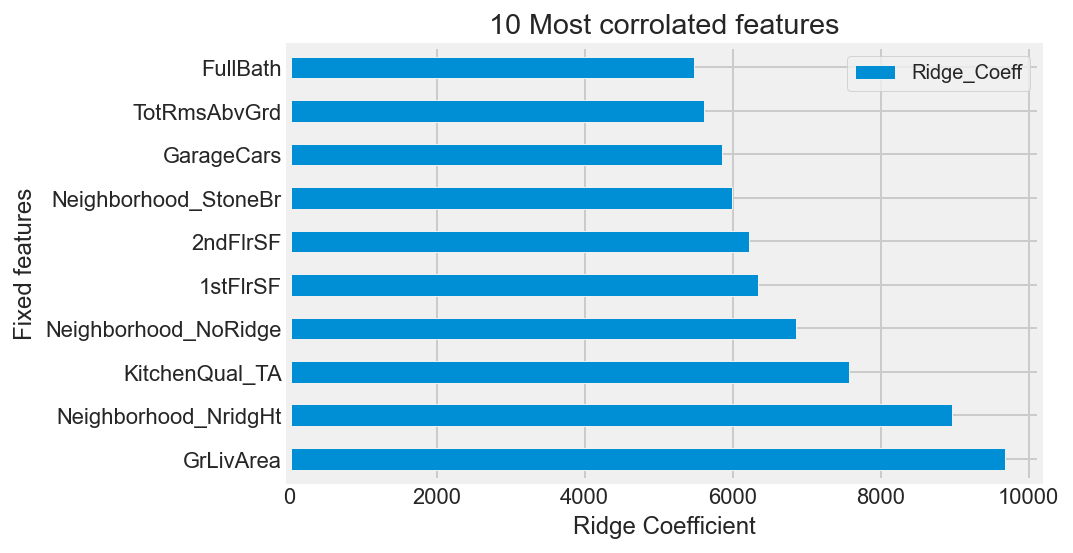

In [125]:
Fixed_most_corrolated.plot(kind = "barh")
plt.tick_params(labelsize=11)
plt.title("10 Most corrolated features")
plt.xlabel("Ridge Coefficient")
plt.ylabel("Fixed features")

In [126]:
y_testpredictridge = rr.predict(X_testss)
y_trainpredictridge = rr.predict(X_trainss)

In [127]:
rr.fit(X_trainss,y_train)

Ridge(alpha=387.20387818125573)

In [128]:
ridge 

Ridge(alpha=387.20387818125573)

In [129]:
LRRTRAIN

Ridge(alpha=387.20387818125573)

In [130]:
#Print out important stuff 

In [131]:
ridgetrain = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, X_trainss, y_train, cv=10)

#print(ridge_scores)
#print(np.mean(ridge_scores))
print("train predicted mean =", np.mean(ridge_scores))

train predicted mean = 0.8055013646926298


In [132]:
ridgetest = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, X_testss, y_test, cv=10)

#print(ridge_scores)
#print(np.mean(ridge_scores))
print("test predicted mean =", np.mean(ridge_scores))

test predicted mean = 0.7570721607426735


In [133]:
print("The RSME for training  is;", np.sqrt(mean_squared_error(y_train,pred_train_rr)))
print("The R^square for training is:", r2_score(y_train, pred_train_rr))

pred_test_rr= rr.predict(X_testss)
print("The RSME for our test dataset is;", np.sqrt(mean_squared_error(y_test,pred_test_rr))) 
print("The R^square for our test dataset is:", r2_score(y_test, pred_test_rr))

The RSME for training  is; 30664.341503146083
The R^square for training is: 0.8517615254838864
The RSME for our test dataset is; 29013.91702298508
The R^square for our test dataset is: 0.8735223449435131


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Q2. Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 of the project: what are the costs/benefits of renovateable features such as quality, condition, and renovations?

To isolate the effect of the renovateable features on the sale price one way of doing this is to use the residuals from the first model as your target variable in the second model. The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. You will use the renovateable features as the predictors for this second model.  

 
---

### **Your goals for question two:**

Use the features in the data that are renovatable as predictors for your second model. This second model will predict the variance/residuals from the first model.  As with Q1 , train the model on pre-2010 data and evaluate its performance on the 2010 houses.

How well has your chosen model done?  


Which renovateable features are the most important in your second model .  Articulate your findings and make sense of the results.

 
Do you trust your model?   

 

In [134]:
#lets check out our residuals

In [135]:
ridge.fit(X_trainss, y_train)


Ridge(alpha=387.20387818125573)

In [136]:
ridge.fit(X_testss, y_test)

Ridge(alpha=387.20387818125573)

In [137]:
ridge_residuals = y_train - ridge.predict(X_trainss)

In [138]:
residualstrain = y_train - ridge.predict(X_trainss)

In [139]:
residualstest = y_test - ridge.predict(X_testss)

In [140]:
houseall

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NA,Reg,Lvl,AllPub,...,0,NA,MnPrv,NA,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NA,Reg,Lvl,AllPub,...,0,NA,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,4,2010,WD,Normal,142125


In [141]:
houseall

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NA,Reg,Lvl,AllPub,...,0,NA,MnPrv,NA,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NA,Reg,Lvl,AllPub,...,0,NA,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,4,2010,WD,Normal,142125


In [142]:
houseall2 = houseall.copy()

In [143]:
#lets make a renovateable exclusive dataset

In [144]:
renovate = houseall2.drop(["LotFrontage","MasVnrArea",'MoSold','SaleType', 'SaleCondition','BsmtUnfSF', 'TotalBsmtSF','YearRemodAdd',"LotArea","GarageArea", "PoolArea","GarageYrBlt","YearBuilt","Fireplaces","GrLivArea","1stFlrSF","2ndFlrSF","LowQualFinSF","Street","LotShape","LandContour","LotConfig","Neighborhood","Condition1","Condition2","BldgType","HouseStyle",
          "RoofStyle","Exterior1st","Exterior2nd","MasVnrType","Foundation","BsmtExposure","BsmtFinType2",
          "KitchenQual","GarageType","PavedDrive","MSSubClass","BsmtFinSF2"
,"BsmtFullBath","BsmtHalfBath","FullBath","HalfBath","BedroomAbvGr","KitchenAbvGr","TotRmsAbvGrd","GarageCars"
  ,"WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch","MiscVal","Id"], axis = 1 )

In [145]:
renovate.columns 

Index(['MSZoning', 'Alley', 'Utilities', 'LandSlope', 'OverallQual',
       'OverallCond', 'RoofMatl', 'ExterQual', 'ExterCond', 'BsmtQual',
       'BsmtCond', 'BsmtFinType1', 'BsmtFinSF1', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'Functional', 'FireplaceQu', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'YrSold',
       'SalePrice'],
      dtype='object')

In [146]:
renovate.shape


(1390, 27)

In [147]:
rentrain = renovate.loc[renovate.YrSold < 2010]
rentest = renovate.loc[renovate.YrSold >= 2010]

In [148]:
#now to make dummies 


In [149]:
rentrain.columns

Index(['MSZoning', 'Alley', 'Utilities', 'LandSlope', 'OverallQual',
       'OverallCond', 'RoofMatl', 'ExterQual', 'ExterCond', 'BsmtQual',
       'BsmtCond', 'BsmtFinType1', 'BsmtFinSF1', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'Functional', 'FireplaceQu', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'YrSold',
       'SalePrice'],
      dtype='object')

In [150]:
To_rendummytrain = rentrain[["SalePrice",'Utilities', 
       'OverallQual', 'OverallCond', 
       'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtFinType1',
         'HeatingQC',
       'Electrical', 'Functional', 'FireplaceQu', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', ]]

To_rendummytest = rentest[["SalePrice",'Utilities', 
       'OverallQual', 'OverallCond', 
       'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtFinType1',
        'HeatingQC',
       'Electrical', 'Functional', 'FireplaceQu', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', ]]


In [151]:
X_trainr2 = pd.get_dummies(data = To_rendummytrain, drop_first = True)
X_testr2 = pd.get_dummies(data = To_rendummytest,drop_first = True)

In [152]:
#Drop saleprice again !
X_trainr = X_trainr2.drop(["SalePrice"], axis = 1)
X_testr = X_testr2.drop(["SalePrice"], axis = 1)

In [153]:
#make sure same features 
X_trainr, X_testr = X_trainr.align(X_testr, fill_value=0, axis=1)

In [154]:
#scaling time 
ss = StandardScaler().fit(X_trainr)

X_trainrss = ss.transform(X_trainr)
X_testrss = ss.transform(X_testr)

In [155]:
X_trainrss

array([[-0.22100495, -0.16384638, -0.04045567, ..., -0.04956816,
         0.07584094, -0.02859478],
       [-0.22100495, -0.16384638, -0.04045567, ..., -0.04956816,
         0.07584094, -0.02859478],
       [-0.22100495, -0.16384638, -0.04045567, ..., -0.04956816,
         0.07584094, -0.02859478],
       ...,
       [-0.22100495, -0.16384638, -0.04045567, ..., -0.04956816,
         0.07584094, -0.02859478],
       [-0.22100495, -0.16384638, -0.04045567, ..., -0.04956816,
         0.07584094, -0.02859478],
       [-0.22100495, -0.16384638, -0.04045567, ..., -0.04956816,
         0.07584094, -0.02859478]])

In [156]:
X_trainr.shape

(1224, 57)

In [157]:
y_trainr = residualstrain
y_testr = residualstest 

In [158]:
print(X_trainrss.shape, y_trainr.shape)
print(X_testrss.shape, y_testr.shape)

(1224, 57) (1224,)
(166, 57) (166,)


In [159]:
#Lets try some models 

In [160]:
ridge_alphasr = np.logspace(0, 5, 200)

optimal_ridger = RidgeCV(alphas=ridge_alphasr, cv=10)
optimal_ridger.fit(X_trainrss, y_trainr)

print(optimal_ridger.alpha_)

410.26581058271944


In [161]:

ridger = Ridge(alpha=488.02515)

ridge_scoresr = cross_val_score(ridge, X_trainrss, y_trainr, cv=10)

print(ridge_scoresr)
print(np.mean(ridge_scoresr))

[ 0.25278215  0.31683932  0.3731882   0.11320114  0.24358595  0.3020698
  0.16904647  0.24232817  0.04051338 -0.15808599]
0.18954685851098493


In [162]:
ridge_alphasr = np.logspace(0, 5, 200)

optimal_ridger = RidgeCV(alphas=ridge_alphasr, cv=10)
optimal_ridger.fit(X_trainrss, y_trainr)

print(optimal_ridger.alpha_)

ridger = Ridge(alpha=488.02515)

ridge_scoresr = cross_val_score(ridge, X_trainrss, y_trainr, cv=10)

print(ridge_scoresr)
print(np.mean(ridge_scoresr))

410.26581058271944
[ 0.25278215  0.31683932  0.3731882   0.11320114  0.24358595  0.3020698
  0.16904647  0.24232817  0.04051338 -0.15808599]
0.18954685851098493


In [163]:
#DO this for lasso and ridge

In [164]:
ridge_alphasr = np.logspace(0, 5, 200)

optimal_ridger = RidgeCV(alphas=ridge_alphasr, cv=10)
optimal_ridger.fit(X_trainrss, y_trainr)

print(optimal_ridger.alpha_)

ridger = Ridge(alpha=488.02515)

ridge_scoresr = cross_val_score(ridge, X_trainrss, y_trainr, cv=10)

print(ridge_scoresr)
print(np.mean(ridge_scoresr))

410.26581058271944
[ 0.25278215  0.31683932  0.3731882   0.11320114  0.24358595  0.3020698
  0.16904647  0.24232817  0.04051338 -0.15808599]
0.18954685851098493


In [167]:
print(optimal_ridger.alpha_)

410.26581058271944


In [168]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(X_testrss, y_testr)

print(optimal_lasso.alpha_)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

112.79259028682182


...................................................................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished


In [172]:
rres = Ridge(alpha=optimal_ridger.alpha_)
ridger = Ridge(alpha=410.26581058271944)

rres.fit(X_trainrss, y_trainr)
rres.fit(X_testrss, y_testr)

ridger_trainscores = cross_val_score(ridger, X_trainrss, y_trainr, cv=10)

ridger_testscores = cross_val_score(ridger, X_testrss, y_testr, cv=10)

ridge_pred_train_rres= rres.predict(X_trainrss)
print("The train predicted mean =", np.mean(ridger_trainscores))
print("The RSME for training  is;", np.sqrt(mean_squared_error(y_trainr,ridge_pred_train_rres)))
print("The R^square for training is:", r2_score(y_trainr, ridge_pred_train_rres))

ridge_pred_test_rres= rres.predict(X_testrss)
print("The test predicted mean =", np.mean(ridger_testscores))
print("The RSME for our test dataset is;", np.sqrt(mean_squared_error(y_testr,ridge_pred_test_rres))) 
print("The R^square for our test dataset is:", r2_score(y_testr, ridge_pred_test_rres))

The train predicted mean = 0.18966813260831505
The RSME for training  is; 36279.5822639618
The R^square for training is: 0.12143856404047604
The test predicted mean = 0.020909631803202287
The RSME for our test dataset is; 28654.766505326035
The R^square for our test dataset is: 0.2088580013189133


In [168]:
#Not great results, but Lets try with lasso 

In [173]:
lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso.fit(X_trainrss, y_trainr)
lasso.fit(X_testrss, y_testr)

lasso_trainscores = cross_val_score(lasso, X_trainrss, y_trainr, cv=10)

lasso_testscores = cross_val_score(lasso, X_testrss, y_testr, cv=10)

lasso_pred_train_rres= lasso.predict(X_trainrss)
print("The train predicted mean =", np.mean(lasso_trainscores))
print("The RSME for training  is;", np.sqrt(mean_squared_error(y_trainr,lasso_pred_train_rres)))
print("The R^square for training is:", r2_score(y_trainr, lasso_pred_train_rres))





lasso_pred_test_rres= lasso.predict(X_testrss)
print("The test predicted mean =", np.mean(lasso_testscores))
print("The RSME for our test dataset is;", np.sqrt(mean_squared_error(y_testr,lasso_pred_test_rres))) 
print("The R^square for our test dataset is:", r2_score(y_testr, lasso_pred_test_rres))

The train predicted mean = 0.0862311030728858
The RSME for training  is; 36312.55486870967
The R^square for training is: 0.11984088175635543
The test predicted mean = 0.17572824864692013
The RSME for our test dataset is; 19003.13404539512
The R^square for our test dataset is: 0.6520545546517912


In [170]:
#Test doesnt'y perform very well - with the mean differning greatly for test and train whilst the r^2 for lasso
#looking odd as well! - due to the size of the disparity of the r^2, will use ridge

In [ ]:
#lets try with lasso

In [174]:
LRRTESTR = lasso.fit(X_testrss, y_testr)
LRRTRAINR = lasso.fit(X_trainrss, y_trainr)

columnsr = X_trainr.columns 

columnsr = pd.DataFrame(columnsr)

coeffsr = pd.DataFrame(LRRTESTR.coef_)

coefficientsr = pd.concat([columnsr, coeffsr], axis = 1 )

coefficientsr = pd.DataFrame.transpose(coefficientsr)

coefficientsr.columns = coefficientsr.iloc[0]

coefficientsr = coefficientsr.iloc[1:, :]

In [175]:
coefficientsr

,BsmtCond_Gd,BsmtCond_NA,BsmtCond_Po,BsmtCond_TA,BsmtFinType1_Gd,BsmtFinType1_NA,BsmtFinType1_Po,BsmtFinType1_TA,BsmtQual_Fa,BsmtQual_Gd,...,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,OverallCond,OverallQual,PoolQC_Fa,PoolQC_Gd,PoolQC_NA,Utilities_NoSeWa
0,32.208119,0.0,825.69818,620.607504,6.908252,26.961002,4.293719,17.522286,-3286.413962,-11258.870334,...,-283.038609,-646.393105,116.448004,525.39916,8461.449961,14207.259685,-6208.296176,-14095.46443,-12082.282899,-668.852855


In [176]:
coeffsr_t = coefficientsr.transpose()
coeffsr_t.columns = ['Ridge_Coeff']
coeffsr_abs = coeffsr_t.abs().sort_values('Ridge_Coeff', ascending=False)
coeffsr_abs

,Ridge_Coeff
0,
OverallQual,14207.259685
PoolQC_Gd,14095.46443
PoolQC_NA,12082.282899
BsmtQual_Gd,11258.870334
BsmtQual_TA,9387.648159
OverallCond,8461.449961
ExterQual_TA,8443.988841
ExterQual_Gd,6883.675738
GarageQual_TA,6692.366083


In [177]:
#Lets find the 10 most

In [178]:
bestren = coeffsr_abs.iloc[0:20]

In [179]:
bestren

,Ridge_Coeff
0,
OverallQual,14207.259685
PoolQC_Gd,14095.46443
PoolQC_NA,12082.282899
BsmtQual_Gd,11258.870334
BsmtQual_TA,9387.648159
OverallCond,8461.449961
ExterQual_TA,8443.988841
ExterQual_Gd,6883.675738
GarageQual_TA,6692.366083


In [180]:
bestren

,Ridge_Coeff
0,
OverallQual,14207.259685
PoolQC_Gd,14095.46443
PoolQC_NA,12082.282899
BsmtQual_Gd,11258.870334
BsmtQual_TA,9387.648159
OverallCond,8461.449961
ExterQual_TA,8443.988841
ExterQual_Gd,6883.675738
GarageQual_TA,6692.366083


Text(0.5, 1.0, 'Renovation features corr.')

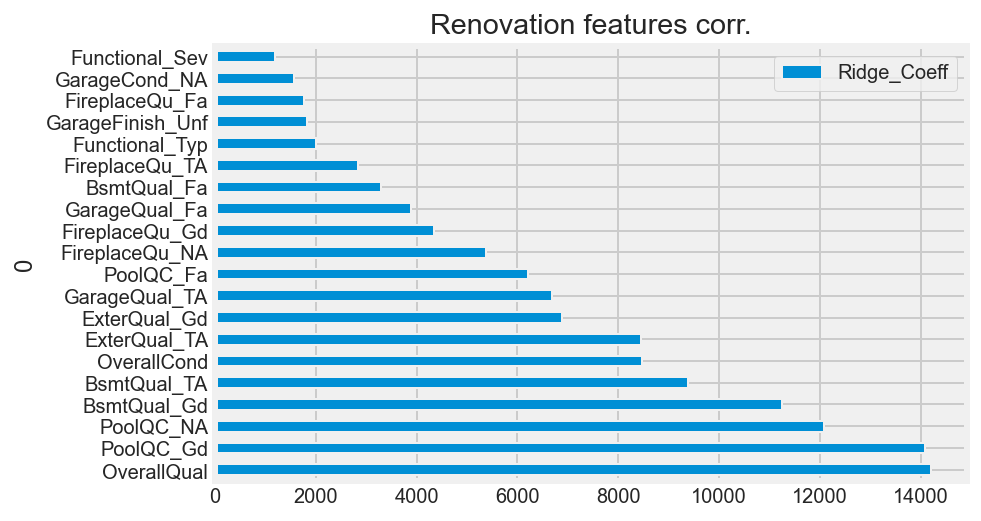

Executing shutdown due to inactivity...


2021-06-05 19:36:59,171 - INFO     - Executing shutdown due to inactivity...


Executing shutdown...


2021-06-05 19:36:59,340 - INFO     - Executing shutdown...


In [181]:
bestren.plot(kind="barh", linewidth = 1,)
plt.title("Renovation features corr.")

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.


 


In [ ]:
# A: